# Complex network

## Course authorities : Karsai / Crespelle / Unicomb

### Students : Mascarade Pierre, Latrille Thibault

Runs on python 2.7.x

# Problem Set Three
## 2. The Erdös-Rényi random graph model

In [1]:
""" IXXI graph library """
from math import ceil
from random import random
from random import sample
from random import choice
from collections import deque
import numpy as np
from math import factorial
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# =========================
#       GRAPH CLASS
# =========================


class Graph(object):
    def __init__(self, graph_dict):
        """ initializes a graph object """
        self.__graph_dict = graph_dict

    def dict(self):
        return self.__graph_dict

    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())

    def sorted_vertices(self):
        """ returns the vertices of a graph """
        return sorted(list(self.__graph_dict.keys()))

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()

    def __len__(self):
        return len(self.vertices())

    def add_vertex(self, vertex):
        """ If the vertex "vertex" is not in
        self.__graph_dict, a key "vertex" with an empty
        list as a value is added to the dictionary.
        Otherwise nothing has to be done.
        """
        if vertex not in self.vertices():
            self.__graph_dict[vertex] = []

    def add_vertices(self, nbr_vertices):
        """ returns the vertices of a graph """
        for vertex in range(nbr_vertices):
            self.add_vertex(vertex)

    def add_edge(self, edge):
        """ It the edge is not in self.__graph_dict,
        the vertices of the edge are added to each other keys
        The function assumes that edge is of type set, tuple or list;
        (no multiple edges)
        """
        if edge[1] not in self.__graph_dict[edge[0]]:
            self.__graph_dict[edge[0]].append(edge[1])
        if edge[0] not in self.__graph_dict[edge[1]]:
            self.__graph_dict[edge[1]].append(edge[0])

    def remove_edge(self, edge):
        """ It the edge is not in self.__graph_dict,
        the vertices of the edge are added to each other keys
        The function assumes that edge is of type set, tuple or list;
        (no multiple edges)
        """
        if edge[1] in self.__graph_dict[edge[0]]:
            self.__graph_dict[edge[0]].remove(edge[1])
        if edge[0] in self.__graph_dict[edge[1]]:
            self.__graph_dict[edge[1]].remove(edge[0])

    def rewire_edge(self, edge1, edge2):
        """ Remove edge1 and add edge2
        """
        self.remove_edge(edge1)
        self.add_edge(edge2)
    
    def __generate_edges(self):
        """ A static method generating the edges of the
        graph "graph". Edges are represented as sets
        two vertices (no loop)
        """
        edges = []
        for vertex_in in self.vertices():
            for vertex_out in self.__graph_dict[vertex_in]:
                if vertex_in < vertex_out:
                    edges.append((vertex_in, vertex_out))
        return edges

    def vertex_degree(self):
        """ returns a list of sets containing the
        name and degree of each vertex of a graph """
        return [(vertex, len(self.__graph_dict[vertex])) for vertex in self.vertices()]

    def degree_sequence(self):
        """ returns as a decreasing list sequence of the vertex degrees of a graph """
        return [degree for _, degree in sorted(self.vertex_degree(), key=lambda x: x[1], reverse=True)]

    def degree_distribution(self):
        """ returns the degree distribution"""
        bincount = np.bincount([len(self.__graph_dict[vertex]) for vertex in self.vertices()])
        return bincount.astype(np.float) / sum(bincount)

    def erdos_gallai(self, sequence):
        """ for a given degree sequence check if it can be
         realised by a simple graph
         returns a boolean"""
        n = len(sequence)
        if sum(sequence) % 2 == 1:
            return False
        for k in range(1, n + 1):
            if not sum(sequence[:k]) <= k * (k - 1) + sum([min(d, k) for d in sequence[k:n]]):
                return False
        return True

    def find_isolated_vertices(self):
        """ returns the list of zero-degree vertices of a graph """
        return [vertex for vertex, degree in self.vertex_degree() if degree == 0]

    def density(self):
        """ returns the density of a graph """
        nbr_edges, nbr_vertices = float(len(self.edges())), float(len(self.vertices()))
        return 2 * nbr_edges / (nbr_vertices * (nbr_vertices - 1))

    def adjacency_matrix(self):
        """ returns the ajacency matrix of a graph
         in the form of a numpy array"""
        v_dict = {}
        for i, v in enumerate(self.vertices()):
            v_dict[v] = i
        n = len(v_dict)
        adj_matrix = [[0 for _ in range(n)] for _ in range(n)]
        for v_i, v_j in self.edges():
            i, j = v_dict[v_i], v_dict[v_j]
            adj_matrix[i][j], adj_matrix[j][i] = 1, 1
        return np.array(adj_matrix)

    def global_clustering_coeff(self):
        """ returns the global clustering coefficient of a graph """
        adj_mtrx = self.adjacency_matrix()
        path_length_two = np.linalg.matrix_power(adj_mtrx, 2)
        closed_triple_mtrx = np.multiply(adj_mtrx, path_length_two)
        n = len(self.vertices())
        nbr_closed_triple, nbr_all_triple = 0.0, 0.0  # float because of division
        nbr_closed_triple += sum(closed_triple_mtrx[i][e] for i in range(n) for e in range(n) if i != e)
        nbr_all_triple += sum(path_length_two[i][e] for i in range(n) for e in range(n) if i != e)
        # instead of not computing the diagonal
        # we could have substract np.trace(path_length_two) from nbr_triple
        return nbr_closed_triple / nbr_all_triple if nbr_all_triple != 0 else 0  # avoid 0 division

    def shortest_path(self, a, b):
        """ returns the shortest path distance between two given vertices a, b"""
        queue = deque()
        distance = {a: 0}
        queue.append(a)
        while len(queue) > 0:
            current = queue.popleft()
            for vertex in self.__graph_dict[current]:
                if vertex == b:
                    return distance[current] + 1
                if vertex not in distance:
                    queue.append(vertex)
                    distance[vertex] = distance[current] + 1
        return float("inf")

    def connected_components(self):
        """ returns a list of sets composed of two elements: the vertices list and the size
        of each connected components of a graph """
        components = []
        set_vertices = set(self.vertices())
        queue = deque()
        while len(set_vertices) > 0:
            init = set_vertices.pop()
            visited = {init: True}
            queue.append(init)
            while len(queue) > 0:
                current = queue.popleft()
                for vertex in self.__graph_dict[current]:
                    if vertex not in visited:
                        queue.append(vertex)
                    visited[vertex] = True
            set_vertices -= set(visited.keys())
            components.append(list(visited.keys()))
        return zip(components, [len(e) for e in components])

    def connected_component_elements(self):
        """ returns a list of the vertices list of each connected components of a graph """
        return map(lambda x: x[0], self.connected_components())

    def connected_component_sizes(self):
        """ returns a list of the size of each connected components of a graph """
        return map(lambda x: x[1], self.connected_components())

    def biggest_component_elements(self):
        return max(self.connected_component_elements(), key=len)

    def component_diameter(self, component):
        """ returns the diameter of a given connected component element of a graph"""
        diameter = 0
        for init in component:
            queue = deque()
            distance = {init: 0}
            queue.append(init)
            while len(queue) > 0:
                current = queue.popleft()
                for vertex in self.__graph_dict[current]:
                    if vertex not in distance:
                        queue.append(vertex)
                        distance[vertex] = distance[current] + 1
            diameter = max((diameter, max(distance.values())))

        return diameter

    def component_average_path_length(self, component):
        """ returns the diameter of a given connected component element of a graph"""
        diameter = []
        for init in component:
            queue = deque()
            distance = {init: 0}
            queue.append(init)
            while len(queue) > 0:
                current = queue.popleft()
                for vertex in self.__graph_dict[current]:
                    if vertex not in distance:
                        queue.append(vertex)
                        distance[vertex] = distance[current] + 1
            diameter.extend(distance.values())
        return np.mean([d for d in diameter if d != 0])

    def biggest_component_average_path_length(self):
        """ returns the diameter of the biggest connected component of a graph """
        return self.component_average_path_length(max(self.connected_component_elements(), key=len))

    def forest_diameters(self):
        """ returns the list of the diameter of each connected components of a graph """
        return [self.component_diameter(component) for component in self.connected_component_elements()]

    def biggest_component_diameter(self):
        """ returns the diameter of the biggest connected component of a graph """
        return self.component_diameter(max(self.connected_component_elements(), key=len))

    def component_spanning_tree(self, component):
        """ returns the spanning tree of a given connected component of a graph """
        spanning_tree = Graph({})
        queue = deque()
        spanning_tree.add_vertex(component.pop())
        queue.extend(spanning_tree.vertices())
        while len(queue) > 0:
            current = queue.popleft()
            for vertex in self.__graph_dict[current]:
                if vertex not in spanning_tree.vertices():
                    queue.append(vertex)
                    spanning_tree.add_vertex(vertex)
                    spanning_tree.add_edge((current, vertex))
        return spanning_tree

    def spanning_forest(self):
        """ returns the list of spanning trees of each connected component of a graph """
        return [self.component_spanning_tree(component) for component in self.connected_component_elements()]

    def biggest_component_spanning_tree(self):
        """ returns the spanning tree of a the biggest connected component of a graph """
        return self.component_spanning_tree(max(self.connected_component_elements(), key=lambda c: len(c)))

    def __str__(self):
        """ A better way for printing a graph """
        res = "vertices: "
        for k in self.__graph_dict:
            res += str(k) + " "
            res += "\nedges: "
        for edge in self.__generate_edges():
            res += str(edge) + " "
        return res


## 2.1 Generating ER graphs

In [3]:
def er_np(n, p):
    """ Create and returns a Erdos-Renyi G_{n,p} random graph,
    where n is the number of vertices and p the probability of puting
    an edge between each two vertices.
    """
    assert 0. <= p <= 1., "p must be a probability, a float between 0. and 1."
    graph = Graph({})
    for vertex in range(n):
        graph.add_vertex(vertex)
    for in_vertex in range(n):
        for out_vertex in range(n):
            if in_vertex < out_vertex:
                if random() < p:
                    graph.add_edge((in_vertex, out_vertex))
    return graph

def er_nm(n, m):
    """ Create and returns a Erdos-Renyi G_{n,m} random graph,
    where n is the number of vertices and m the number of edges.
    """
    m, n = int(m), int(n)
    assert (n * (n-1) / 2) >= m, "Too many edges for the number of vertices"
    graph = Graph({})
    for vertex in range(n):
        graph.add_vertex(vertex)

    for in_vertex, out_vertex in sample([(v_i, v_o)
                                         for v_i in set(range(n))
                                         for v_o in set(range(n))
                                         if v_i < v_o], m):
            graph.add_edge((in_vertex, out_vertex))
    return graph

## 2.2 Degree distributions of random graphs

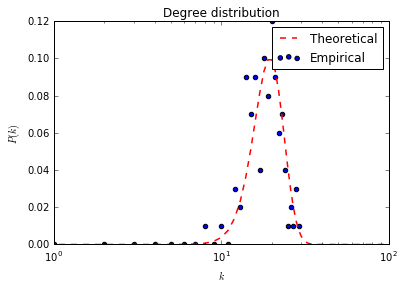

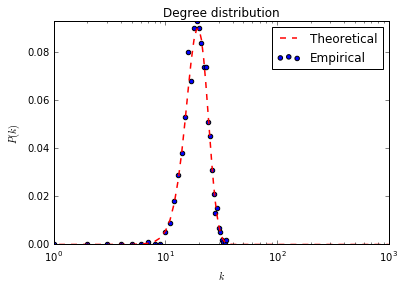

In [4]:
def nbr_combination(n, r):
    """ Return the choice of r among n
    """
    return factorial(n) / (factorial(r) * factorial(n-r))

def plot_degree_distribution_erdos_renyi(n, p):
    """ Plot the theoretical and empirical degree distribution of G_{n,p}
    """
    graph = er_np(n, p)
    hist = graph.degree_distribution()

    degrees = range(len(hist))

    plt.scatter(degrees, hist, label='Empirical')
    plt.plot(range(n), [nbr_combination(n-1, e)*(p**e)*((1-p)**(n-e-1)) for e in range(n)],
             'r--', linewidth=1.5, label='Theoretical')

    plt.xscale('log')
    plt.xlim(1, n)
    plt.ylim(0, max(hist))
    plt.xlabel(r'$k$')
    plt.ylabel(r'$P(k)$')
    plt.title('Degree distribution')
    plt.legend()

    plt.show()

plot_degree_distribution_erdos_renyi(100, 0.2)
plot_degree_distribution_erdos_renyi(1000, 0.02)

We see that empirical degree distribution of $G_{n,p}$ match the theoretical distribution.

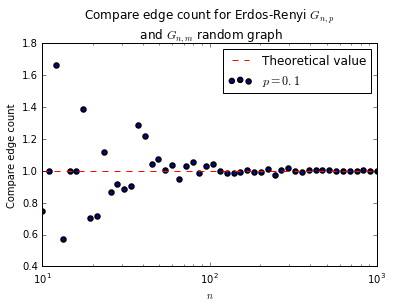

In [5]:
def compare_edge_count(n, p):
    """ Return the ratio of the number of edges
        in the corresponding G_{n,p} and G_{n,m} graphs
    """
    m = int(p * nbr_combination(n, 2))
    return float(len(er_np(n, p).edges())) / m


def plot_compare_edge_count(n, p):
    """ Plot the empirical compare_edge_count and theoretical value for increasing 
    value of n
    """
    n_max = max(n, 20)
    x = np.logspace(1, np.log10(n_max), 50)
    plt.scatter(x, [compare_edge_count(int(e), p) for e in x],
                linewidth=2, label="$p={}$".format(p))
    plt.plot((10, n_max), (1, 1), 'r--', label="Theoretical value")
    plt.xlim(10, n_max)
    plt.xscale('log')
    plt.xlabel('$n$')
    plt.ylabel('Compare edge count')
    plt.title("Compare edge count for Erdos-Renyi $G_{n,p}$ \n and $G_{n,m}$ random graph")
    plt.legend()
    plt.show()

plot_compare_edge_count(1000, 0.1)

We see that for $n>100$, $G_{n,p}$ and $G_{n,m}$ are empirically equivalent in terms of number of edges. 

## 2.3 The Erdös-Rényi model and connected components

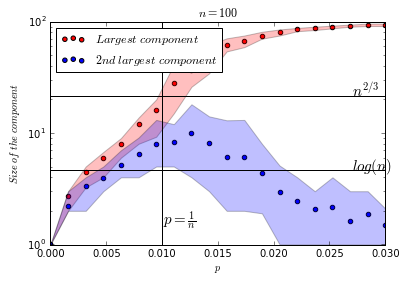

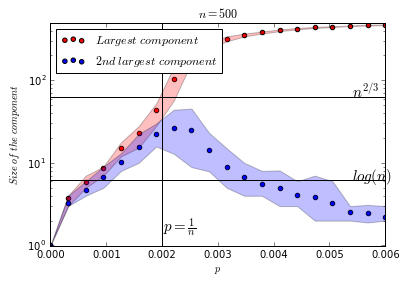

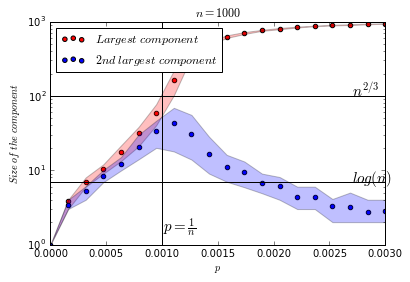

In [6]:
def plot_connected_components_erdos_renyi(n, replicate=50):
    """ Plot the size (number of vertices) of the first and second largest component 
    of G_{n,p} for p around the 1/n threshold
    """
    p_max = 3. / n
    range_p = np.linspace(0, p_max, 20)
    sorted_sizes_list = [[sorted(er_np(int(n), p).connected_component_sizes(), reverse=True)
                          for _ in range(replicate)]
                         for p in range_p]

    first_size_list = [[sorted_sizes[0] for sorted_sizes in sorted_sizes_range]
               for sorted_sizes_range in sorted_sizes_list]
    plt.scatter(range_p, np.mean(first_size_list, axis=1), c='r', label="$Largest\ component$")
    plt.fill_between(range_p, np.percentile(first_size_list, 25, axis=1),
                              np.percentile(first_size_list, 75, axis=1), facecolor='r', alpha=0.25)

    sec_size_list = [[(sorted_sizes[1] if len(sorted_sizes) > 1 else 0) for sorted_sizes in sorted_sizes_range]
               for sorted_sizes_range in sorted_sizes_list]
    plt.scatter(range_p, np.mean(sec_size_list, axis=1), c='b', label="$2{nd}\ largest\ component$")
    plt.fill_between(range_p, np.percentile(sec_size_list, 10, axis=1),
                              np.percentile(sec_size_list, 90, axis=1), facecolor='b', alpha=0.25)

    plt.plot((0, p_max), (np.log(n), np.log(n)), 'black')
    plt.text(p_max*0.90, np.log(n), r'$log(n)$', fontsize=15)
    plt.plot((0, p_max), (np.power(n, 2./3), np.power(n, 2./3)), 'black')
    plt.text(p_max*0.90, np.power(n, 2./3), r'$n^{2/3}$', fontsize=15)
    plt.plot((1./n, 1./n), (0, n), 'black')

    plt.title("$n = {}$".format(n))

    plt.xlabel(r'$p$')
    plt.ylabel(r'$Size\ of\ the\ component$')
    plt.yscale('log')

    plt.text(1.01 / n, 1.5, r'$p=\frac{1}{n}$', fontsize=15)
    plt.xlim(0, p_max)
    plt.ylim(0, n)
    plt.legend(loc=2)
    plt.show()

plot_connected_components_erdos_renyi(100)
plot_connected_components_erdos_renyi(500)
plot_connected_components_erdos_renyi(1000)

The dots are the average over 50 replicates, the filled interval are the 80% confidence interval.
The second largest component has it's maximum for $p=1/n$, meaning by increasing $p$ above the $1/n$ threshold the components aggregates to the largest one.

We thus see that $p=1/n$ is a threshold for the connectivity of $G_{n,p}$ graph.

- if $np < 1$, a graph in $G_{n,p}$ will almost surely have no connected components of size larger than $O(log n)$

- if $np = 1$, a graph in $G_{n,p}$ will almost surely have a largest component whose size is $O(n^{2/3})$

- if $np → c > 1$, where $c$ is a constant, then a graph in $G_{n,p}$ will almost surely have a unique giant
component containing a positive fraction of the vertices. No other component will contain more than $O(log n)$ vertices.

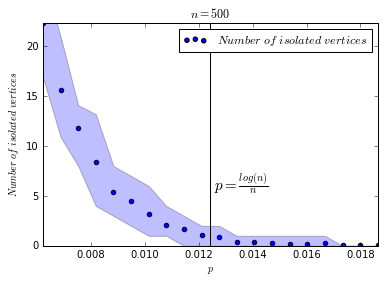

In [7]:
def plot_isolated_vertices_erdos_renyi(n, replicate=50):
    """ Plot the number of isolated vertices of G_{n,p} 
    for p around the log(n)/n threshold 
    """
    th = np.log(n) / n
    p_max = min(1, 1.5 * th)
    p_min = max(0, 0.5 * th)
    range_p = np.linspace(p_min, p_max, 20)
    sorted_sizes_list = [[sorted(er_np(int(n), p).connected_component_sizes(), reverse=True) 
                          for _ in range(replicate)]
                         for p in range_p]

    isolated_vertices = [[len([s for s in sorted_sizes if s == 1]) for sorted_sizes in sorted_sizes_range]
                  for sorted_sizes_range in sorted_sizes_list]
    plt.scatter(range_p, np.mean(isolated_vertices, axis=1),
                c='b', label="$Number\ of\ isolated\ vertices$")
    plt.fill_between(range_p, np.percentile(isolated_vertices, 10, axis=1),
                              np.percentile(isolated_vertices, 90, axis=1), facecolor='b', alpha=0.25)
    plt.plot((th, th), (0, n), 'black')

    plt.title("$n = {}$".format(n))

    plt.xlabel(r'$p$')
    plt.ylabel(r'$Number\ of\ isolated\ vertices$')

    plt.xlim(p_min, p_max)
    plt.text(th*1.01, np.mean(isolated_vertices[0])*0.25, r'$p=\frac{log(n)}{n}$', fontsize=15)
    plt.ylim(0, np.mean(isolated_vertices[0]))
    plt.legend()
    plt.show()

plot_isolated_vertices_erdos_renyi(500)

We see that $p=log(n)/n$ is a threshold for isolated vertices of $G_{n,p}$ graph.

- if $\frac{np}{log n} <  1$, a graph in $G_{n,p}$ will almost surely contain isolated vertices

- if $\frac{np}{log n} >  1$, a graph in $G_{n,p}$ will almost surely be connected.

# Problem Set Three

## 1. The Watts-Strogatz model

In [8]:
def unique_choice(seq, not_element, not_seq):
    """ Return 1 unique elements from seq. Must satisfy that this element is different
    to 'not_element' and must not be in 'not_seq'
    """
    target = 0
    while 1:
        target = choice(seq)
        if target != not_element and target not in not_seq:
            break
    return target


def watts_strogatz(n=1000, k=50, beta=0.5):
    """ Create and returns a Watts-Strogatz random graph,
        where n is the number of vertices, k the number of adjacent edges,
        and beta the probability of rewiring.
    """
    assert 0. <= beta <= 1., "Watts-Strogatz graph must have 0. <= beta <= 1."
    assert k % 2 == 0, "Watts-Strogatz graph must have k be an even integer"
    assert 1 < k < n, "Watts-Strogatz graph must have 1 < k < n"
    graph = Graph({})
    graph.add_vertices(n)
    for vertex in graph.vertices():
        for ring_vertex in range(int(k/2)):
            graph.add_edge((vertex, (vertex + (ring_vertex + 1)) % n))
            graph.add_edge((vertex, (vertex - (ring_vertex + 1)) % n))
    if beta > 0.:
        for v_i in graph.vertices():
            for v_j in graph.dict()[v_i]:
                if v_i < v_j and random() <= beta:
                    v_l = unique_choice(graph.vertices(), v_i, graph.dict()[v_i])
                    graph.rewire_edge((v_i, v_j), (v_i, v_l))
    return graph

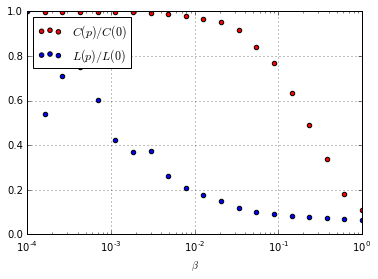

In [9]:
def plot_watts_strogatz(n, k):
    """ Plot the average path length and the clustering coefficient of Watt-Strogatz graph, for beta 
    between 0 and 1.
    """
    # the histogram of the data
    list_beta = np.logspace(-4, 0, 20)

    list_graph = [watts_strogatz(n, k, beta) for beta in list_beta]
    wso = watts_strogatz(n, k, 0.)
    max_clustering_coef = wso.global_clustering_coeff()
    list_clustering_coef = [graph.global_clustering_coeff() / max_clustering_coef for graph in list_graph]
    max_diameter = wso.biggest_component_average_path_length()
    list_diameter = [graph.biggest_component_average_path_length() / max_diameter for graph in list_graph]

    plt.scatter(list_beta, list_clustering_coef, c='r', label=r'$C(p)/C(0)$')
    plt.scatter(list_beta, list_diameter, c='b', label=r'$L(p)/L(0)$')
    plt.legend(loc=2)

    plt.xscale('log')
    plt.xlabel(r'$\beta$')
    plt.ylim(0, 1)
    plt.xlim(min(list_beta), max(list_beta))
    plt.grid(True)

    plt.show()
    
plot_watts_strogatz(1000, 10)

We succedded in reproducing the figure 2 of the paper  of Duncan J. Watts & Steven H. Strogatz (1998).

Plot of the average path length $L(p)$ and clustering coefficient $C(p)$ for the Watts-Strogatz graphs. Here $L$ is defined as the number of edges in the shortest path between two vertices, averaged over all pairs of vertices. The clustering coefficient $C$ is defined as in the problem set one.

This figures reveals that there is a broad interval of $\beta$ over which $L(p)$ is small (almost as small as for the equivalent $G_{n,p}$) because of the introduction of a few long-range edges but maintains the high-clustering coefficient of the regular ring-lattice.

**Collective dynamics of 'small-world' networks**, Duncan J. Watts & Steven H. Strogatz (1998), [https://dx.doi.org/10.1038/30918](https://dx.doi.org/10.1038/30918)

## 2. Barabási-Albert Model

In [10]:
def unique_sample(seq, m):
    """ Return m unique elements from seq.

    This differs from sample which can return repeated
    elements if seq holds repeated elements.
    """
    targets = set()
    while len(targets) < m:
        x = choice(seq)
        targets.add(x)
    return targets

def barabasi_albert(mo=2, m=2, n=1000, inital_graph={}):
    """ Create and returns a Barabasi-Albert random graph,
        where n is the number of vertices and m the number of edges for each added vertex.
    """
    assert 1 <= m <= mo <= n, "m < mo < n"
    graph = er_np(mo, 1)
    repeated_vertices = [v for edge in graph.edges() for v in edge]
    for vertex in range(mo, n):
        graph.add_vertex(vertex)
        targets = unique_sample(repeated_vertices, m)
        for v_target in targets:
            graph.add_edge((vertex, v_target))
        repeated_vertices.extend(targets)
        repeated_vertices.extend([vertex]*m)
    return graph

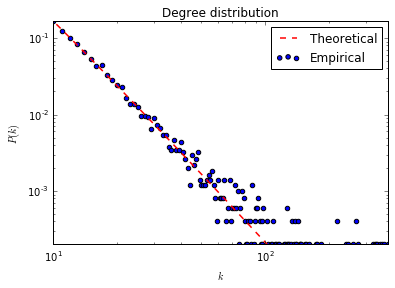

In [11]:
def plot_degree_distribution_barabasi_albert(mo, m, n):
    """ Plot the theoretical and empirical degree distribution of Barabasi-Albert
    """
    graph = barabasi_albert(mo, m, n)
    hist = graph.degree_distribution()

    degrees = range(len(hist))

    plt.scatter(degrees, hist, label='Empirical')
    plt.plot(degrees[1:], [2.*m*(m+1)/(k*(k+1)*(k+2)) for k in degrees[1:]],
             'r--', linewidth=1.5, label='Theoretical')

    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(degrees[next((i for i, h in enumerate(hist) if h != 0), 1)], len(degrees))
    plt.ylim(min([h for h in hist if h != 0]), max(hist))
    plt.xlabel(r'$k$')
    plt.ylabel(r'$P(k)$')
    plt.title('Degree distribution')
    plt.legend()
    plt.show()
    
plot_degree_distribution_barabasi_albert(mo=10, m=10, n=5000)

Plot of the empirical degree distribution of the Barabási-Albert.  
The theoretical value is computed as in Krapivsky *et al* (2000): $P(k) = \frac{2 m (m+2)}{k(k+1)(k+2)} \sim k^{-3}$ and implies $\gamma = 3$. In loglog scale the power law function is a straight line, with slope $-3$.

**Connectivity of Growing Random Networks**, Krapivsky *et al*, 2000, [https://doi.org/10.1103/PhysRevLett.85.4629](https://doi.org/10.1103/PhysRevLett.85.4629)

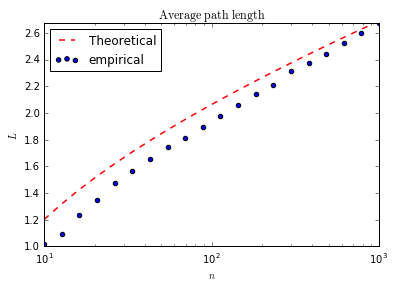

In [12]:
def plot_path_length_barabasi_albert(mo, m, n_max):
    """ Plot the average path length of Barabasi-Albert graph, for different value of n
    """
    range_n = np.logspace(np.log10(10), np.log10(n_max), 20)
    list_graph = [barabasi_albert(mo, m, int(n)) for n in range_n]
    list_diameter = [graph.biggest_component_average_path_length() for graph in list_graph]

    plt.scatter(range_n, list_diameter, label='empirical')
    plt.plot(range_n, 1.5 + (np.log(range_n)-np.log(m / 2.)-1.5772) / (np.log(np.log(range_n))+np.log(m/2.)),
             'r--', linewidth=1.5, label='Theoretical')
    plt.xlabel(r'$n$')
    plt.ylabel(r'$L$')
    plt.title(r'$\mathrm{Average\ path\ length}$')

    plt.xscale('log')
    plt.xlim(10, n_max)
    plt.ylim(1, max(list_diameter))
    plt.legend(loc=2)

    plt.show()
    

plot_path_length_barabasi_albert(mo=8, m=8, n_max=1000)

Plot of the empirical average path length ($L$) for different value of $n$ for Barabási-Albert graphs.  
The theoretical value is computed as in Fronczak *et al* (2004): $L \sim \frac{log(n) - log(m/2) - 1.5722}{log(log(n))+log(m/2)} + \frac{3}{2} \sim  \frac{log(n)}{log(log(n))}$.  
Thus Barabási-Albert graph display property of ultra small world network in terms of the average path length.
  
**Average path length in random networks**, Fronczak *et al*, 2004, [https://doi.org/10.1103/PhysRevE.70.056110](https://doi.org/10.1103/PhysRevE.70.056110)

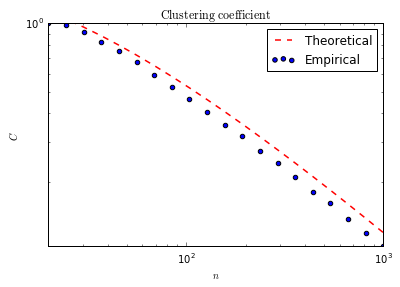

In [13]:
def plot_clustering_barabasi_albert(mo, m, n_max):
    """ Plot the average path length of Barabasi-Albert graph, for different value of n
    """
    range_n = np.logspace(np.log10(mo), np.log10(n_max), 20)
    list_graph = [barabasi_albert(mo, m, int(n)) for n in range_n]
    list_clustering = [graph.global_clustering_coeff() for graph in list_graph]
    plt.scatter(range_n, list_clustering, label='Empirical')
    plt.plot(range_n, m*np.divide(1, range_n) * np.power(np.log(range_n), 2) / 8.,
             'r--', linewidth=1.5, label='Theoretical')
    plt.xlabel(r'$n$')
    plt.ylabel(r'$C$')
    plt.title(r'$\mathrm{Clustering\ coefficient}$')

    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(mo, n_max)
    plt.ylim(min(list_clustering), max(list_clustering))
    plt.legend()
    plt.show()
    
plot_clustering_barabasi_albert(mo=20, m=20, n_max=1000)

Plot of the empirical clustering coefficient $C$ for different value of $n$ for  Barabási-Albert graphs.  
The theoretical value is computed as in Klemm *et al* (2002): $C \sim \frac{m}{8}\frac{log(n)^2}{n}$.  

This means the Barabási-Albert graphs fails to reproduce a high clustering coefficient with short path length, thus it is not a small-world network.

**Growing scale-free networks with small-world behavior**, Klemm *et al*, 2002, [https://doi.org/10.1103/PhysRevE.65.057102](https://doi.org/10.1103/PhysRevE.65.057102)